In [2]:
import math
import carla
import numpy as np
from enum import IntEnum
import networkx as nx
from collections import deque
import pickle
import matplotlib.pyplot as plt

In [3]:

class RoadOption(IntEnum):
    """
    RoadOption represents the possible topological configurations when moving from a segment of lane to other.

    """
    VOID = -1
    LEFT = 1
    RIGHT = 2
    STRAIGHT = 3
    LANEFOLLOW = 4
    CHANGELANELEFT = 5
    CHANGELANERIGHT = 6

In [4]:


def get_speed(vehicle):
    """
    Get the speed of a vehicle.

    Args:
        vehicle (carla.Vehicle): Vehicle object.

    Returns:
        float: Speed of the vehicle in km/h.
    """
    vel = vehicle.get_velocity()
    return 3.6 * math.sqrt(vel.x ** 2 + vel.y ** 2 + vel.z ** 2)

# Class for PID Longitudinal Controller
class PIDLongitudinalController():
    """
    PID Longitudinal Controller for vehicle speed control.
    """
    def __init__(self, vehicle, K_P=1.0, K_I=0.0, K_D=0.0, dt=0.03):
        """
        Initialize PID controller parameters and error buffer.

        Args:
            vehicle (carla.Vehicle): Vehicle object.
            K_P (float, optional): Proportional gain. Defaults to 1.0.
            K_I (float, optional): Integral gain. Defaults to 0.0.
            K_D (float, optional): Derivative gain. Defaults to 0.0.
            dt (float, optional): Time step. Defaults to 0.03.
        """
        # Initializing PID controller parameters and error buffer
        self._vehicle = vehicle
        self._k_p = K_P
        self._k_i = K_I
        self._k_d = K_D
        self._dt = dt
        self._error_buffer = deque(maxlen=10)

    def run_step(self, target_speed, debug=False):
        """
        Execute a step of PID control based on target speed and current speed.

        Args:
            target_speed (float): Target speed in km/h.
            debug (bool, optional): Debug mode flag. Defaults to False.

        Returns:
            float: Control action output.
        """
        # Running PID control step based on target speed and current speed
        current_speed = get_speed(self._vehicle)
        if debug:
            print('Current speed = {}'.format(current_speed))
        return self._pid_control(target_speed, current_speed)

    def _pid_control(self, target_speed, current_speed):
        # Calculating PID control action
        error = target_speed - current_speed
        self._error_buffer.append(error)

        if len(self._error_buffer) >= 2:
            _de = (self._error_buffer[-1] - self._error_buffer[-2]) / self._dt
            _ie = sum(self._error_buffer) * self._dt
        else:
            _de = 0.0
            _ie = 0.0

        return np.clip((self._k_p * error) + (self._k_d * _de) + (self._k_i * _ie), -1.0, 1.0)

In [5]:


# Class for Pure Pursuit Controller
class PurePursuitController():
    """
    Pure Pursuit Controller for lateral control.
    """
    def __init__(self, L, Kdd):
        """
        Initialize Pure Pursuit controller parameters.

        Args:
            L (float): Vehicle's wheelbase.
            Kdd (float): Gain for calculating lookahead distance.
        """
        # Initializing Pure Pursuit controller parameters
        self.L = L
        self.Kdd = Kdd
        self.delta_prev = 0

    def calc_steering_angle(self, alpha, ld):
        # Calculating steering angle based on alpha and lookahead distance
        R = ld/2*np.sin(alpha) #new
        delta = math.atan2(2 * self.L * np.sin(alpha), ld)
        delta = np.fmax(np.fmin(delta, 1.0), -1.0)
        if math.isnan(delta):
            delta = self.delta_prev
        else:
            self.delta_prev = delta
        return delta #new

    def get_target_wp_index(self, veh_location, waypoint_list):
        # Finding the index of the target waypoint in the list
        dxl, dyl = [], []
        for i in range(len(waypoint_list)):
            dx = abs(veh_location.x - waypoint_list[i][0])
            dxl.append(dx)
            dy = abs(veh_location.y - waypoint_list[i][1])
            dyl.append(dy)

        dist = np.hypot(dxl, dyl)
        idx = np.argmin(dist) + 15

        if idx < len(waypoint_list):
            tx = waypoint_list[idx][0]
            ty = waypoint_list[idx][1]
        else:
            tx = waypoint_list[-1][0]
            ty = waypoint_list[-1][1]

        return idx, tx, ty, dist

    def get_lookahead_dist(self, vf, idx, waypoint_list, dist):
        # Calculating lookahead distance
        ld = self.Kdd * vf
        return ld

In [6]:


# Function to calculate distance between vehicle location and a target
def find_dist_veh(vehicle_loc, target):
    """
    Calculate distance between vehicle location and a target.

    Args:
        vehicle_loc (carla.Location): Vehicle's location.
        target (carla.Actor): Target actor.

    Returns:
        float: Distance between vehicle and target.
    """
    dist = math.sqrt((target.transform.location.x - vehicle_loc.x)**2 + (target.transform.location.y - vehicle_loc.y)**2)
    return dist

# Function to get the speed of a vehicle
def get_speed(vehicle):
    """
    Get the speed of a vehicle.

    Args:
        vehicle (carla.Vehicle): Vehicle object.

    Returns:
        float: Speed of the vehicle in km/h.
    """
    vel = vehicle.get_velocity()
    return 3.6 * math.sqrt(vel.x ** 2 + vel.y ** 2 + vel.z ** 2)

def vector(location_1, location_2):
    """
    Returns the unit vector from location_1 to location_2

        :param location_1, location_2: carla.Location objects
    """
    x = location_2.x - location_1.x
    y = location_2.y - location_1.y
    z = location_2.z - location_1.z
    norm = np.linalg.norm([x, y, z]) + np.finfo(float).eps

    return [x / norm, y / norm, z / norm]

# Function to generate control signal for the vehicle
def control_signal(vehicle, waypoint_list, longitudinal_controller: PIDLongitudinalController, lateral_controller: PurePursuitController, speed, waypoint, past_steering):
    """
    Generate control signal for the vehicle.

    Args:
        vehicle (carla.Vehicle): Vehicle object.
        waypoint_list (list): List of waypoints.
        longitudinal_controller (PIDLongitudinalController): Longitudinal controller object.
        lateral_controller (PurePursuitController): Lateral controller object.
        speed (float): Current speed of the vehicle.
        waypoint (carla.Waypoint): Current waypoint.
        past_steering (float): Previous steering angle.

    Returns:
        carla.VehicleControl: Control commands for the vehicle.
    """
    # Setting maximum values for throttle, brake, and steering
    max_throttle = 0.75
    max_brake = 0.8
    max_steering = 0.8
    control = carla.VehicleControl()

    # Calculating acceleration based on longitudinal controller output
    acceleration = longitudinal_controller.run_step(speed)
    

    # Calculating vehicle properties
    veh_transform = vehicle.get_transform()
    veh_location = vehicle.get_location()
    veh_vel = vehicle.get_velocity()
    vf = np.sqrt(veh_vel.x**2 + veh_vel.y**2)
    vf = np.fmax(np.fmin(vf, 2.5), 0.1)

    # Finding target waypoint index and calculating lookahead distance
    min_index, tx, ty, dist = lateral_controller.get_target_wp_index(veh_location, waypoint_list)
    ld = lateral_controller.get_lookahead_dist(vf, min_index, waypoint_list, dist)

    # Calculating alpha and lateral error
    yaw = np.radians(veh_transform.rotation.yaw)
    alpha = math.atan2(ty - veh_location.y, tx - veh_location.x) - yaw

    if math.isnan(alpha):
        alpha = alpha_prev
    else:
        alpha_prev = alpha

    e = np.sin(alpha) * ld

    # Calculating current steering angle
    current_steering = lateral_controller.calc_steering_angle(alpha, ld) #new

    if acceleration >= 0.0:
        control.throttle = min(acceleration, max_throttle)
        control.brake = 0.0
    else:
        control.throttle = 0.0
        control.brake = min(abs(acceleration), max_brake)



    # #new from here
    # # Assume you have access to the current_steering and R values
    # current_steering, R = lateral_controller.calc_steering_angle(alpha, ld)  # new

    # # Define threshold values for determining a turn
    # straight_road_threshold = 100  # Adjust this value according to your scenario

    # if 1/abs(R) > straight_road_threshold:
    #     # Vehicle is on a straight road
    #     print(f'Curvature when moving on straight line {R = }')
    #     if acceleration >= 0.0:
    #         control.throttle = min(acceleration, max_throttle)
    #         control.brake = 0.0
    #     else:
    #         control.throttle = 0.0
    #         control.brake = 0.20#min(abs(acceleration), max_brake)
    # else:
    #     # Vehicle is on a turn
    #     # Adjust throttle and brake accordingly
    #     # You might want to decrease throttle or apply brakes based on the turn radius
    #     # Example: reduce throttle or apply brakes if R is less than a certain value
    #     print(f'Curvature when moving on curve {R = }')
    #     if acceleration >= 0.0:
    #         control.throttle = min(acceleration, max_throttle * 0.50)  # Adjust the factor according to your scenario
    #         control.brake =  max_brake * 0.40
    #     else:
    #         control.throttle = 0.05
    #         control.brake = min(abs(acceleration), max_brake * 0.90)  # Adjust the factor according to your scenario

    # #to here

    # Applying constraints to steering angle changes
    if current_steering > past_steering + 0.1:
        current_steering = past_steering + 0.1
    elif current_steering < past_steering - 0.1:
        current_steering = past_steering - 0.1

    if current_steering >= 0:
        steering = min(max_steering, current_steering)
    else:
        steering = max(-max_steering, current_steering)

    control.steer = steering

    # Setting other control properties
    control.hand_brake = False
    control.manual_gear_shift = False

    return control#new

In [7]:

class GlobalRoutePlanner(object):
    """
    This class provides a very high level route plan.
    """

    def __init__(self, wmap, sampling_resolution):
        self._sampling_resolution = sampling_resolution
        self._wmap = wmap
        self._topology = None
        self._graph = None
        self._id_map = None
        self._road_id_to_edge = None

        self._intersection_end_node = -1
        self._previous_decision = RoadOption.VOID

        # Build the graph
        self._build_topology()
        self._build_graph()
        self._find_loose_ends()
        self._lane_change_link()

    def trace_route(self, origin, destination):
        """
        This method returns list of (carla.Waypoint, RoadOption)
        from origin to destination
        """
        route_trace = []
        route = self._path_search(origin, destination)
        current_waypoint = self._wmap.get_waypoint(origin)
        destination_waypoint = self._wmap.get_waypoint(destination)

        for i in range(len(route) - 1):
            road_option = self._turn_decision(i, route)
            edge = self._graph.edges[route[i], route[i+1]]
            path = []

            if edge['type'] != RoadOption.LANEFOLLOW and edge['type'] != RoadOption.VOID:
                route_trace.append((current_waypoint, road_option))
                exit_wp = edge['exit_waypoint']
                n1, n2 = self._road_id_to_edge[exit_wp.road_id][exit_wp.section_id][exit_wp.lane_id]
                next_edge = self._graph.edges[n1, n2]
                if next_edge['path']:
                    closest_index = self._find_closest_in_list(current_waypoint, next_edge['path'])
                    closest_index = min(len(next_edge['path'])-1, closest_index+5)
                    current_waypoint = next_edge['path'][closest_index]
                else:
                    current_waypoint = next_edge['exit_waypoint']
                route_trace.append((current_waypoint, road_option))

            else:
                path = path + [edge['entry_waypoint']] + edge['path'] + [edge['exit_waypoint']]
                closest_index = self._find_closest_in_list(current_waypoint, path)
                for waypoint in path[closest_index:]:
                    current_waypoint = waypoint
                    route_trace.append((current_waypoint, road_option))
                    if len(route)-i <= 2 and waypoint.transform.location.distance(destination) < 2*self._sampling_resolution:
                        break
                    elif len(route)-i <= 2 and current_waypoint.road_id == destination_waypoint.road_id and current_waypoint.section_id == destination_waypoint.section_id and current_waypoint.lane_id == destination_waypoint.lane_id:
                        destination_index = self._find_closest_in_list(destination_waypoint, path)
                        if closest_index > destination_index:
                            break

        return route_trace

    def _build_topology(self):
        """
        This function retrieves topology from the server as a list of
        road segments as pairs of waypoint objects, and processes the
        topology into a list of dictionary objects with the following attributes

        - entry (carla.Waypoint): waypoint of entry point of road segment
        - entryxyz (tuple): (x,y,z) of entry point of road segment
        - exit (carla.Waypoint): waypoint of exit point of road segment
        - exitxyz (tuple): (x,y,z) of exit point of road segment
        - path (list of carla.Waypoint):  list of waypoints between entry to exit, separated by the resolution
        """
        self._topology = []
        # Retrieving waypoints to construct a detailed topology
        for segment in self._wmap.get_topology():
            wp1, wp2 = segment[0], segment[1]
            l1, l2 = wp1.transform.location, wp2.transform.location
            # Rounding off to avoid floating point imprecision
            x1, y1, z1, x2, y2, z2 = np.round([l1.x, l1.y, l1.z, l2.x, l2.y, l2.z], 0)
            wp1.transform.location, wp2.transform.location = l1, l2
            seg_dict = dict()
            seg_dict['entry'], seg_dict['exit'] = wp1, wp2
            seg_dict['entryxyz'], seg_dict['exitxyz'] = (x1, y1, z1), (x2, y2, z2)
            seg_dict['path'] = []
            endloc = wp2.transform.location
            if wp1.transform.location.distance(endloc) > self._sampling_resolution:
                w = wp1.next(self._sampling_resolution)[0]
                while w.transform.location.distance(endloc) > self._sampling_resolution:
                    seg_dict['path'].append(w)
                    next_ws = w.next(self._sampling_resolution)
                    if len(next_ws) == 0:
                        break
                    w = next_ws[0]
            else:
                next_wps = wp1.next(self._sampling_resolution)
                if len(next_wps) == 0:
                    continue
                seg_dict['path'].append(next_wps[0])
            self._topology.append(seg_dict)

    def _build_graph(self):
        """
        This function builds a networkx graph representation of topology, creating several class attributes:
        - graph (networkx.DiGraph): networkx graph representing the world map, with:
            Node properties:
                vertex: (x,y,z) position in world map
            Edge properties:
                entry_vector: unit vector along tangent at entry point
                exit_vector: unit vector along tangent at exit point
                net_vector: unit vector of the chord from entry to exit
                intersection: boolean indicating if the edge belongs to an  intersection
        - id_map (dictionary): mapping from (x,y,z) to node id
        - road_id_to_edge (dictionary): map from road id to edge in the graph
        """

        self._graph = nx.DiGraph()
        self._id_map = dict()  # Map with structure {(x,y,z): id, ... }
        self._road_id_to_edge = dict()  # Map with structure {road_id: {lane_id: edge, ... }, ... }

        for segment in self._topology:
            entry_xyz, exit_xyz = segment['entryxyz'], segment['exitxyz']
            path = segment['path']
            entry_wp, exit_wp = segment['entry'], segment['exit']
            intersection = entry_wp.is_junction
            road_id, section_id, lane_id = entry_wp.road_id, entry_wp.section_id, entry_wp.lane_id

            for vertex in entry_xyz, exit_xyz:
                # Adding unique nodes and populating id_map
                if vertex not in self._id_map:
                    new_id = len(self._id_map)
                    self._id_map[vertex] = new_id
                    self._graph.add_node(new_id, vertex=vertex)
            n1 = self._id_map[entry_xyz]
            n2 = self._id_map[exit_xyz]
            if road_id not in self._road_id_to_edge:
                self._road_id_to_edge[road_id] = dict()
            if section_id not in self._road_id_to_edge[road_id]:
                self._road_id_to_edge[road_id][section_id] = dict()
            self._road_id_to_edge[road_id][section_id][lane_id] = (n1, n2)

            entry_carla_vector = entry_wp.transform.rotation.get_forward_vector()
            exit_carla_vector = exit_wp.transform.rotation.get_forward_vector()

            # Adding edge with attributes
            self._graph.add_edge(
                n1, n2,
                length=len(path) + 1, path=path,
                entry_waypoint=entry_wp, exit_waypoint=exit_wp,
                entry_vector=np.array(
                    [entry_carla_vector.x, entry_carla_vector.y, entry_carla_vector.z]),
                exit_vector=np.array(
                    [exit_carla_vector.x, exit_carla_vector.y, exit_carla_vector.z]),
                net_vector=vector(entry_wp.transform.location, exit_wp.transform.location),
                intersection=intersection, type=RoadOption.LANEFOLLOW)

    def _find_loose_ends(self):
        """
        This method finds road segments that have an unconnected end, and
        adds them to the internal graph representation
        """
        count_loose_ends = 0
        hop_resolution = self._sampling_resolution
        for segment in self._topology:
            end_wp = segment['exit']
            exit_xyz = segment['exitxyz']
            road_id, section_id, lane_id = end_wp.road_id, end_wp.section_id, end_wp.lane_id
            if road_id in self._road_id_to_edge \
                    and section_id in self._road_id_to_edge[road_id] \
                    and lane_id in self._road_id_to_edge[road_id][section_id]:
                pass
            else:
                count_loose_ends += 1
                if road_id not in self._road_id_to_edge:
                    self._road_id_to_edge[road_id] = dict()
                if section_id not in self._road_id_to_edge[road_id]:
                    self._road_id_to_edge[road_id][section_id] = dict()
                n1 = self._id_map[exit_xyz]
                n2 = -1*count_loose_ends
                self._road_id_to_edge[road_id][section_id][lane_id] = (n1, n2)
                next_wp = end_wp.next(hop_resolution)
                path = []
                while next_wp is not None and next_wp \
                        and next_wp[0].road_id == road_id \
                        and next_wp[0].section_id == section_id \
                        and next_wp[0].lane_id == lane_id:
                    path.append(next_wp[0])
                    next_wp = next_wp[0].next(hop_resolution)
                if path:
                    n2_xyz = (path[-1].transform.location.x,
                              path[-1].transform.location.y,
                              path[-1].transform.location.z)
                    self._graph.add_node(n2, vertex=n2_xyz)
                    self._graph.add_edge(
                        n1, n2,
                        length=len(path) + 1, path=path,
                        entry_waypoint=end_wp, exit_waypoint=path[-1],
                        entry_vector=None, exit_vector=None, net_vector=None,
                        intersection=end_wp.is_junction, type=RoadOption.LANEFOLLOW)

    def _lane_change_link(self):
        """
        This method places zero cost links in the topology graph
        representing availability of lane changes.
        """

        for segment in self._topology:
            left_found, right_found = False, False

            for waypoint in segment['path']:
                if not segment['entry'].is_junction:
                    next_waypoint, next_road_option, next_segment = None, None, None

                    if waypoint.right_lane_marking and waypoint.right_lane_marking.lane_change & carla.LaneChange.Right and not right_found:
                        next_waypoint = waypoint.get_right_lane()
                        if next_waypoint is not None \
                                and next_waypoint.lane_type == carla.LaneType.Driving \
                                and waypoint.road_id == next_waypoint.road_id:
                            next_road_option = RoadOption.CHANGELANERIGHT
                            next_segment = self._localize(next_waypoint.transform.location)
                            if next_segment is not None:
                                self._graph.add_edge(
                                    self._id_map[segment['entryxyz']], next_segment[0], entry_waypoint=waypoint,
                                    exit_waypoint=next_waypoint, intersection=False, exit_vector=None,
                                    path=[], length=0, type=next_road_option, change_waypoint=next_waypoint)
                                right_found = True
                    if waypoint.left_lane_marking and waypoint.left_lane_marking.lane_change & carla.LaneChange.Left and not left_found:
                        next_waypoint = waypoint.get_left_lane()
                        if next_waypoint is not None \
                                and next_waypoint.lane_type == carla.LaneType.Driving \
                                and waypoint.road_id == next_waypoint.road_id:
                            next_road_option = RoadOption.CHANGELANELEFT
                            next_segment = self._localize(next_waypoint.transform.location)
                            if next_segment is not None:
                                self._graph.add_edge(
                                    self._id_map[segment['entryxyz']], next_segment[0], entry_waypoint=waypoint,
                                    exit_waypoint=next_waypoint, intersection=False, exit_vector=None,
                                    path=[], length=0, type=next_road_option, change_waypoint=next_waypoint)
                                left_found = True
                if left_found and right_found:
                    break

    def _localize(self, location):
        """
        This function finds the road segment that a given location
        is part of, returning the edge it belongs to
        """
        waypoint = self._wmap.get_waypoint(location)
        edge = None
        try:
            edge = self._road_id_to_edge[waypoint.road_id][waypoint.section_id][waypoint.lane_id]
        except KeyError:
            pass
        return edge

    def _distance_heuristic(self, n1, n2):
        """
        Distance heuristic calculator for path searching
        in self._graph
        """
        l1 = np.array(self._graph.nodes[n1]['vertex'])
        l2 = np.array(self._graph.nodes[n2]['vertex'])
        return np.linalg.norm(l1-l2)

    def _path_search(self, origin, destination):
        """
        This function finds the shortest path connecting origin and destination
        using A* search with distance heuristic.
        origin      :   carla.Location object of start position
        destination :   carla.Location object of of end position
        return      :   path as list of node ids (as int) of the graph self._graph
        connecting origin and destination
        """
        start, end = self._localize(origin), self._localize(destination)

        route = nx.astar_path(
            self._graph, source=start[0], target=end[0],
            heuristic=self._distance_heuristic, weight='length')
        route.append(end[1])
        return route

    def _successive_last_intersection_edge(self, index, route):
        """
        This method returns the last successive intersection edge
        from a starting index on the route.
        This helps moving past tiny intersection edges to calculate
        proper turn decisions.
        """

        last_intersection_edge = None
        last_node = None
        for node1, node2 in [(route[i], route[i+1]) for i in range(index, len(route)-1)]:
            candidate_edge = self._graph.edges[node1, node2]
            if node1 == route[index]:
                last_intersection_edge = candidate_edge
            if candidate_edge['type'] == RoadOption.LANEFOLLOW and candidate_edge['intersection']:
                last_intersection_edge = candidate_edge
                last_node = node2
            else:
                break

        return last_node, last_intersection_edge

    def _turn_decision(self, index, route, threshold=math.radians(35)):
        """
        This method returns the turn decision (RoadOption) for pair of edges
        around current index of route list
        """

        decision = None
        previous_node = route[index-1]
        current_node = route[index]
        next_node = route[index+1]
        next_edge = self._graph.edges[current_node, next_node]
        if index > 0:
            if self._previous_decision != RoadOption.VOID \
                    and self._intersection_end_node > 0 \
                    and self._intersection_end_node != previous_node \
                    and next_edge['type'] == RoadOption.LANEFOLLOW \
                    and next_edge['intersection']:
                decision = self._previous_decision
            else:
                self._intersection_end_node = -1
                current_edge = self._graph.edges[previous_node, current_node]
                calculate_turn = current_edge['type'] == RoadOption.LANEFOLLOW and not current_edge[
                    'intersection'] and next_edge['type'] == RoadOption.LANEFOLLOW and next_edge['intersection']
                if calculate_turn:
                    last_node, tail_edge = self._successive_last_intersection_edge(index, route)
                    self._intersection_end_node = last_node
                    if tail_edge is not None:
                        next_edge = tail_edge
                    cv, nv = current_edge['exit_vector'], next_edge['exit_vector']
                    if cv is None or nv is None:
                        return next_edge['type']
                    cross_list = []
                    for neighbor in self._graph.successors(current_node):
                        select_edge = self._graph.edges[current_node, neighbor]
                        if select_edge['type'] == RoadOption.LANEFOLLOW:
                            if neighbor != route[index+1]:
                                sv = select_edge['net_vector']
                                cross_list.append(np.cross(cv, sv)[2])
                    next_cross = np.cross(cv, nv)[2]
                    deviation = math.acos(np.clip(
                        np.dot(cv, nv)/(np.linalg.norm(cv)*np.linalg.norm(nv)), -1.0, 1.0))
                    if not cross_list:
                        cross_list.append(0)
                    if deviation < threshold:
                        decision = RoadOption.STRAIGHT
                    elif cross_list and next_cross < min(cross_list):
                        decision = RoadOption.LEFT
                    elif cross_list and next_cross > max(cross_list):
                        decision = RoadOption.RIGHT
                    elif next_cross < 0:
                        decision = RoadOption.LEFT
                    elif next_cross > 0:
                        decision = RoadOption.RIGHT
                else:
                    decision = next_edge['type']

        else:
            decision = next_edge['type']

        self._previous_decision = decision
        return decision

    def _find_closest_in_list(self, current_waypoint, waypoint_list):
        min_distance = float('inf')
        closest_index = -1
        for i, waypoint in enumerate(waypoint_list):
            distance = waypoint.transform.location.distance(
                current_waypoint.transform.location)
            if distance < min_distance:
                min_distance = distance
                closest_index = i

        return closest_index


In [31]:
import time

In [99]:
start_wp = []
end_wp = []
waypoints_x = []
waypoints_y = []
vehicle_positions_x = []
vehicle_positions_y = []

# Main function
def main(town_name:str):
    client = carla.Client('localhost', 2000)
    client.set_timeout(40.0)
    world = client.load_world(town_name)

    amap = world.get_map()
    sampling_resolution = 0.5
    grp = GlobalRoutePlanner(amap, sampling_resolution)

    spawn_points = world.get_map().get_spawn_points()


    start = np.random.choice(spawn_points)
    start_wp.append((start.location.x, start.location.y))
    
    end = np.random.choice(spawn_points)
    end_wp.append((end.location.x, end.location.y))

    a = carla.Location(start.location)
    b = carla.Location(end.location)

    w1 = grp.trace_route(a, b) 

    world.debug.draw_point(a,color=carla.Color(r=255, g=0, b=0),size=0.4 ,life_time=120.0)
    world.debug.draw_point(b,color=carla.Color(r=255, g=0, b=0),size=0.4 ,life_time=120.0)


    wps=[]

    for i in range(len(w1)):
        
        wp = w1[i][0].transform.location
        waypoints_x.append(wp.x)
        waypoints_y.append(wp.y)

        wps.append(w1[i][0])
        world.debug.draw_point(w1[i][0].transform.location,color=carla.Color(r=255, g=0, b=0),size=0.05 ,life_time=120.0)

    waypoint_list = []

    for i, wp in enumerate(wps):
        waypoint_list.insert(i, (wp.transform.location.x, wp.transform.location.y)) 
        
        

    spawnPoint=start
    world = client.get_world()
    blueprint_library = world.get_blueprint_library()
    bp = blueprint_library.find('vehicle.lincoln.mkz_2020')
    vehicle = world.spawn_actor(bp, spawnPoint)


    L = 2.5
    # Kdd = 1.4 best
    Kdd = 7.0

    long_controller = PIDLongitudinalController(vehicle, K_P = 1.0 , K_D = 0.0, K_I = 0.75 , dt = 1.0 / 10.0 )
    lat_controller = PurePursuitController(L, Kdd)

    #speed=45 #sahi
    speed = 25


    i=0
    target=wps[0]
    past_steering = vehicle.get_control().steer

    prev_vehicle_loc = vehicle.get_location()
    same_loc_count = 0
    max_same_loc_count = 100

    while True:

        spectator = world.get_spectator() 
        transform = carla.Transform(vehicle.get_transform().transform(carla.Location(x=-4,z=2.5)),vehicle.get_transform().rotation) 
        spectator.set_transform(transform) 

        vehicle_loc= vehicle.get_location()
        vehicle_positions_x.append(vehicle_loc.x)
        vehicle_positions_y.append(vehicle_loc.y)
        
        distance_v =find_dist_veh(vehicle_loc,target)
        
        control = control_signal(vehicle, waypoint_list, long_controller, lat_controller, speed, wps, past_steering) #new

        # print(R) #new
        past_steering = control.steer       
        
        
        vehicle.apply_control(control)

        if vehicle_loc.distance(prev_vehicle_loc) < 0.05:  # Adjust the distance threshold as needed
            same_loc_count += 1
        else:
            same_loc_count = 0

        if same_loc_count > max_same_loc_count:
            print("Vehicle location remains constant. Exiting simulation.")
            break

        
        prev_vehicle_loc = vehicle_loc
        time.sleep(0.01)
        
        if i==(len(wps)-1):
            print("last waypoint reached")
            break 
        
        
        if (distance_v>10.0): #3.5
            control = control_signal(vehicle, waypoint_list, long_controller, lat_controller, speed, target, past_steering)
            past_steering = control.steer 
            i=i+1
            target=wps[i]
            

    control = control_signal(vehicle, waypoint_list, long_controller, lat_controller, 0, target, past_steering)
    past_steering = control.steer 
    vehicle.apply_control(control)
    vehicle.destroy()

    data_to_save = {'start_wp': start_wp,
                    'end_wp' : end_wp,
                    'waypoints_x': waypoints_x,
                    'waypoints_y': waypoints_y,
                    'vehicle_positions_x': vehicle_positions_x,
                    'vehicle_positions_y': vehicle_positions_y
                    }

    with open('simulation_data.pkl', 'wb') as file:
        pickle.dump(data_to_save, file)

town = 'Town01'
if __name__ == '__main__':
    main(town)

last waypoint reached


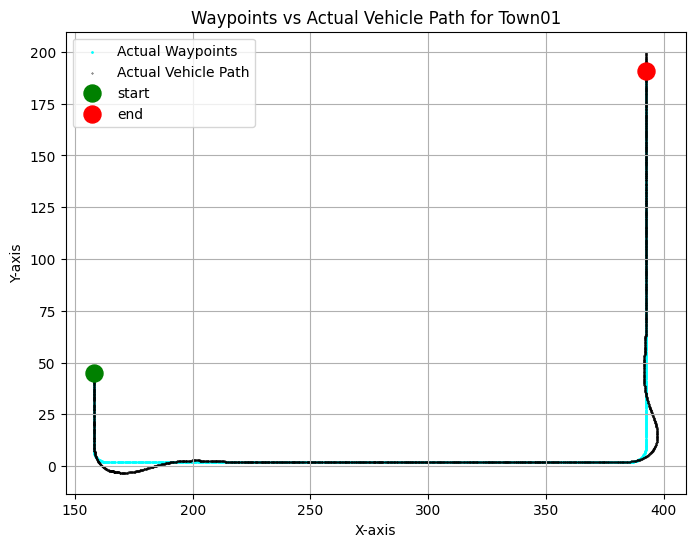

In [100]:
with open('simulation_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Extract loaded data
start_wp = loaded_data['start_wp']
end_wp = loaded_data['end_wp']

waypoints_x = loaded_data['waypoints_x']
waypoints_y = loaded_data['waypoints_y']

vehicle_positions_x = loaded_data['vehicle_positions_x']
vehicle_positions_y = loaded_data['vehicle_positions_y']

# Plot waypoints and vehicle path
plt.figure(figsize=(8, 6))
plt.scatter(waypoints_x, waypoints_y, color = 'cyan', label='Actual Waypoints', s=1)
plt.scatter(vehicle_positions_x, vehicle_positions_y, color = 'black', label='Actual Vehicle Path', s = 0.1)

plt.scatter(start_wp[0][0], start_wp[0][1], color='green', label='start', s=150)  # Setting the size to 50
plt.scatter(end_wp[0][0], end_wp[0][1], color='red', label='end', s=150)  # Setting the size to 50

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Waypoints vs Actual Vehicle Path for {town}')
plt.legend()
plt.grid(True)
plt.savefig(rf'C:\Users\jasde\Desktop\689\Plots\{town}\shitty_params\output3.png')
plt.show()


In [8]:
len(waypoints_x)

889

In [9]:
len(vehicle_positions_x)

889

In [10]:
import numpy as np

# Assuming you have collected ground truth waypoints and vehicle positions
# waypoints_x, waypoints_y, vehicle_positions_x, vehicle_positions_y

def calculate_rmse(waypoints_x, waypoints_y, vehicle_positions_x, vehicle_positions_y):
    waypoints = np.array([waypoints_x, waypoints_y]).T
    vehicle_positions = np.array([vehicle_positions_x, vehicle_positions_y]).T

    # Ensure the lengths are the same
    assert len(waypoints) == len(vehicle_positions)

    # Calculate RMSE
    squared_error = np.sum((waypoints - vehicle_positions) ** 2, axis=1)
    rmse = np.sqrt(np.mean(squared_error))
    
    return rmse

# Calculate RMSE after the simulation
error = calculate_rmse(waypoints_x, waypoints_y, vehicle_positions_x, vehicle_positions_y)
print("Root Mean Square Error (RMSE):", error)

Root Mean Square Error (RMSE): 155.89116348730215


In [11]:
print("Waypoints Length:", len(waypoints_x))
print("Vehicle Positions Length:", len(vehicle_positions_x))


Waypoints Length: 889
Vehicle Positions Length: 889


In [12]:
1518/377

4.026525198938992

In [3]:
client = carla.Client('localhost', 2000)
client.set_timeout(40.0)
world = client.load_world('Town01')

In [5]:
actors = world.get_actors()
len(actors)

173

In [7]:
for actor in actors:
    if 'traffic.traffic_light' in actor.type_id:
        actor.destroy()

In [8]:
len(actors)

173